# Lecture 7: Group by

## Some configuration and imports

In [12]:
# download function for a plot
!wget 'https://raw.githubusercontent.com/ReDI-School/python-data-science/master/redi/ws_18/utils/groupby_plot.py'
import groupby_plot


Redirecting output to ‘wget-log.2’.


In [13]:
# for writing to excel
!pip install xlwt

In [0]:
%matplotlib inline

import pandas as pd

## Another request for the BI Team
```
Dear BI Team, 

I need to know the total revenue we made. Furthermore, I also need the total revenue we made with each of our products. Please give this data to me as an excel file. Can you also provide me with a list of the 5 products that made most revenue, and the 5 products that made least revenue?

Dankeschön ihr Schatzis xxx
```

By now, you should be comfortable with solving the first request (the total revenue).

**Task:** Load the data and calculate the total revenue (sum over `sales_price`)

In [0]:
# Load the resellers data set
url = 'https://raw.githubusercontent.com/ReDI-School/python-data-science/master/datasets/reseller/orders.csv'
data = pd.read_csv(url, parse_dates=['datetime_ordered'])

In [16]:
# Display the total revenue
data.sales_price.sum()

3775.5299999999997

What you did above is an aggregation (or more specifically, as summation) over the column `sales_price`. For the second request, we need to split up the column data into groups before aggregating. In pandas, these sorts of operations can by readily done on data frames with the `groupby` method. Before we try out stuff on our resellers data set, let's first get some intuition about the pandas `groupby`.

## Group By explained

Before we try to solve the request on our reseller data set, let's first look into a small toy data frame containing the sales of three products:

In [17]:
sales = pd.DataFrame({'product': ['1', '2', '3', '1', '2', '3'], 
                      'price': [10, 20, 30, 40, 50, 60]}
                    )
sales

,price,product
0,10,1
1,20,2
2,30,3
3,40,1
4,50,2
5,60,3


Can you describe in words what you would do in order to calculate the total revenue for each product?

### Split (into groups) -> Aggregate (the groups) -> Combine (the results)
What you probably did in order to get to total revenue per product, is could be called split->aggregate->combine. Let's visualize these operations:

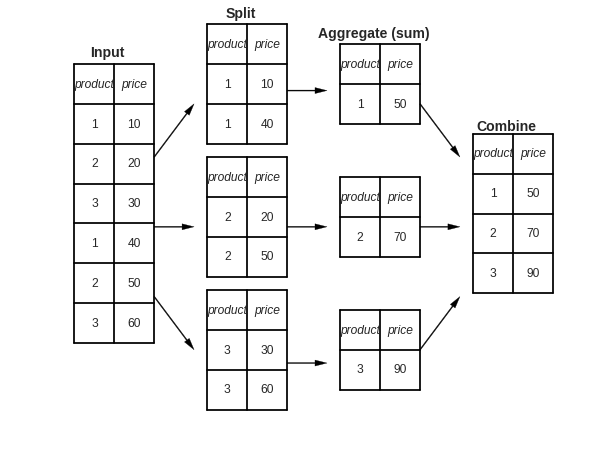

In [18]:
groupby_plot.plot()

*Nerd info:* The above plot was generated in python. If you want to check the source code, try executing `??groupby_plot.plot` in the notebook. In fact, I adapted it from this excellent resource https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html.

In the pandas docs, the group by operations are called more generally split-apply-combine. You can read about it in here https://pandas.pydata.org/pandas-docs/stable/groupby.html.

**Task**: Now try to get to total revenue per product on the toy data frame `sales`:

In [10]:
sales.groupby('product').sum()

,price
product,
1,50
2,70
3,90


### Inspecting the individual groups after the "split" step
If we want to know more deeply what's going on within the groupby, we can actually inspect the groups after the "split" step:

In [9]:
grouped = sales.groupby('product')
grouped

The groupby without the aggregation function yields a `DataFrameGroupBy` object. This is a special view of the oroiginal data frame, prepared for iterating over the groups and doing the aggregation (the "aggregate" and "combine" steps). 

Let's now iterate over individual groups:

In [10]:
for (product, group) in grouped:
    print("product:", product)
    print(group)
    print(type(group), '\n')

product: 1
   price product
0     10       1
3     40       1
<class 'pandas.core.frame.DataFrame'> 

product: 2
   price product
1     20       2
4     50       2
<class 'pandas.core.frame.DataFrame'> 

product: 3
   price product
2     30       3
5     60       3
<class 'pandas.core.frame.DataFrame'> 



###  "aggregate" and "combine" done manually
We can see that the individual groups are just plain data frames. Hence, we can easily do the "aggregate" step like so:

In [0]:
products = []
aggregations = []
for (product, group) in grouped:
    aggregations.append(group['price'].sum())
    products.append(product)

This gives us the aggregations...

In [12]:
aggregations

[50, 70, 90]

...and the group identifiers (the products):

In [13]:
products

['1', '2', '3']

Whats now missing is the "combine" step:

In [14]:
pd.DataFrame(aggregations, columns=['price'], index=products).rename_axis('product')

,price
product,
1,50
2,70
3,90


### Custom "aggregate" functions
Pandas allows to do basically arbitrary aggregations on the groups using custom functions. Let's write such a function. As we've seen above, the individual groups are data frames, so the function should take a data frame as its input:

In [0]:
# Let's re-implement the sum function 
# (this is a stupid idea, you should always use the pandas version)
def my_sum(df):
    return df['price'].sum()  

We can now use the `agg()` function to aggregate using `my_sum()`.

In [16]:
sales.groupby('product').agg(my_sum)

,price
product,
1,50
2,70
3,90


## Back to the request

```
...
Furthermore, I also need the total revenue we made with each of our products. Please give this data to me as an excel file. Can you also provide me with a list of the 5 products that made most revenue, and the 5 products that made least revenue?
```

In [17]:
data.head(2)

,order_id,product_id,purchase_price,sales_price,customer_id,used_promo_code,datetime_ordered
0,177,9493,89.0,119.99,325,True,2018-06-27 17:20:50
1,255,3771,31.0,49.99,436,False,2018-06-17 04:54:24


In [11]:
# Get total revenue for each product
revenue_per_product = data.groupby('product_id')['sales_price'].sum()
revenue_per_product.head()

product_id
37     279.96
221     39.99
492     59.98
774      3.50
933    179.97
Name: sales_price, dtype: float64

In [0]:
# export as excel file
revenue_per_product.to_excel('revenue_per_product.xls')

In [20]:
# check that the excel file is there
! ls *.xls

revenue_per_product.xls


In [0]:
# download it
from google.colab import files
files.download('revenue_per_product.xls')

In [22]:
# show the top 5 products
revenue_per_product.sort_values(ascending=False).head()

product_id
9493    479.96
2920    329.97
5860    303.92
5425    279.96
37      279.96
Name: sales_price, dtype: float64

In [23]:
# worst 5 products
revenue_per_product.sort_values(ascending=False).tail()

product_id
8141    13.99
6902     8.98
4076     7.00
1837     6.99
774      3.50
Name: sales_price, dtype: float64

## Multiple aggregations
```
I also want to know the mean and max revenue per product.
```

In [24]:
data.groupby('product_id').sales_price.agg(['mean', 'max', 'count'])

,mean,max,count
product_id,,,
37,69.99,69.99,4
221,39.99,39.99,1
492,29.99,29.99,2
774,3.50,3.50,1
933,59.99,59.99,3
1228,14.99,14.99,3
1254,9.99,9.99,4
1425,59.99,59.99,4
1837,6.99,6.99,1


It looks like the sales price is always the same for each product!

**Nerd Task:** For each product, get a boolean variable that tells if the product was always sold for the same price (`True`) or not (`False`)

In [0]:
def check_unique(x):
    return x.nunique() == 1

In [26]:
same_price = data.groupby('product_id').sales_price.agg(check_unique)
same_price.head()

product_id
37     True
221    True
492    True
774    True
933    True
Name: sales_price, dtype: bool

In [27]:
same_price.all()

True

# Aggregations over multiple columns

In [28]:
# aggregates over all numeric columns
data.groupby('product_id').mean().head()

,order_id,purchase_price,sales_price,customer_id,used_promo_code
product_id,,,,,
37,371.5,44.0,69.99,1372.000000,0.500000
221,239.0,28.5,39.99,2508.000000,1.000000
492,443.0,16.0,29.99,1816.500000,0.000000
774,835.0,3.0,3.50,4190.000000,0.000000
933,724.0,37.0,59.99,494.333333,0.333333


In [29]:
# pass a dictionary to `agg()` to get aggregate columns differently
agg_dict = {'purchase_price': 'median', 
            'used_promo_code': 'mean'}
data.groupby('product_id').agg(agg_dict).head()

,purchase_price,used_promo_code
product_id,,
37,44.0,0.500000
221,28.5,1.000000
492,16.0,0.000000
774,3.0,0.000000
933,37.0,0.333333


In [0]:
## Grouping by multiple columns

In [31]:
data.groupby(['product_id', 'used_promo_code']).purchase_price.mean()

product_id  used_promo_code
37          False              44.00
            True               44.00
221         True               28.50
492         False              16.00
774         False               3.00
933         False              37.00
            True               37.00
1228        False               7.40
            True                7.40
1254        False               6.00
            True                6.00
1425        False              38.00
1837        False               3.50
2419        False              14.00
            True               14.00
2448        False               6.70
2577        False              17.00
2920        False              82.00
2958        False              12.55
            True               12.55
3484        False              14.00
3617        False               4.80
3771        False              31.00
4076        False               3.00
4187        False               4.40
            True                4.40
5157      

# Yet another request from the CEO
```
Can you display what's the average revenue we make per each day of weak? And also per hour of the day please?
```

In [0]:
data['day'] = data.datetime_ordered.dt.dayofweek
data['hour'] = data.datetime_ordered.dt.hour

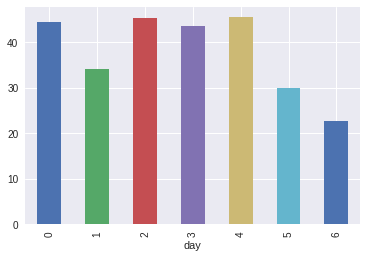

In [33]:
data.groupby('day').sales_price.mean().plot(kind='bar');

What's do the day numbers mean??

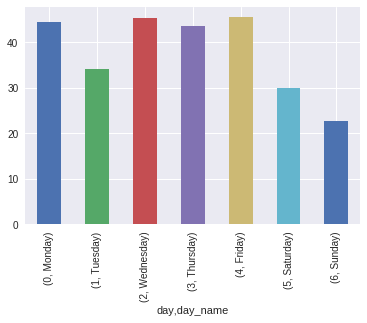

In [34]:
data['day_name'] = data.datetime_ordered.dt.weekday_name
data.groupby(['day', 'day_name']).sales_price.mean().plot(kind='bar');

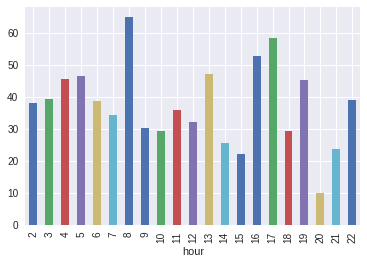

In [35]:
data.groupby('hour').sales_price.mean().plot(kind='bar')

**Nerd Task:** What's the order_id with the highest sales price for each day of week? Have a look at the `DataFrameGroupBy.idxmax` function.

In [36]:
data.groupby(['day', 'day_name']).sales_price.max()

day  day_name 
0    Monday       109.99
1    Tuesday       69.99
2    Wednesday    119.99
3    Thursday     119.99
4    Friday       119.99
5    Saturday     119.99
6    Sunday        59.99
Name: sales_price, dtype: float64

In [0]:
index = data.groupby(['day']).sales_price.idxmax()

In [38]:
index

day
0    90
1    89
2     0
3    57
4    24
5    18
6     7
Name: sales_price, dtype: int64

In [39]:
data.loc[index, ['day', 'day_name', 'order_id', 'sales_price']]

,day,day_name,order_id,sales_price
90,0,Monday,580,109.99
89,1,Tuesday,606,69.99
0,2,Wednesday,177,119.99
57,3,Thursday,680,119.99
24,4,Friday,226,119.99
18,5,Saturday,697,119.99
7,6,Sunday,841,59.99
